In [1]:
%load_ext autoreload
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, precision_recall_curve, auc, accuracy_score
import nibabel

import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from IPython.core.debugger import set_trace
import os

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchio as tio

import yaml
from easydict import EasyDict as edict

from utils import check_patch, pad_arrays, normalize, load, create_dicts, trim, video, video_comparison
from IPython.core.display import display, HTML
from train import DiceScoreBinary
from datasets import create_datasets

from multiprocessing import cpu_count
N_CPU = cpu_count()

SEED = 42
%autoreload 2

# torchio patches

In [27]:
# root = '/nfs/garfield/ibulygin/tensors_v2/'
# metadata = np.load('/nfs/garfield/ibulygin/metadata_v2.npy',allow_pickle=True).item()
# metadata_key = 'test'
# labels = metadata[metadata_key]

# paths = [os.path.join(root, f'tensor_{k}') for k in labels]

In [9]:
# len(metadata['train'])

In [28]:
# plt.ioff()
# camera = video_comparison(list(tensor_dict.values()))
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [34]:
# idx = 0
# tensor_dict = torch.load(paths[idx])
# brain_tensor_torch = tensor_dict['T1w'].unsqueeze(0)
# mask_tensor_torch = tensor_dict['mask']
# label_tensor_torch = tensor_dict['label']

# brain_tensor_torch, label_tensor_torch, mask_tensor_torch = trim(brain_tensor_torch, 
#                                                                 label_tensor_torch,
#                                                                 mask_tensor_torch)



In [2]:
# N_fcd = label_tensor_torch.sum()
# N_brain = mask_tensor_torch.sum()

# k = N_brain / N_fcd
# p = 1/(1+k)

# sampling_map = mask_tensor_torch.clone()
# sampling_map[label_tensor_torch.type(torch.bool)] = int(k)

# Training

In [55]:
# model = torchvision.models.video.r2plus1d_18(pretrained=False, progress=True) 

# conv3d_1 = model.stem[0]
# model.stem[0] = nn.Conv3d(in_channels=1,
#                                      out_channels=conv3d_1.out_channels,
#                                      kernel_size=conv3d_1.kernel_size,
#                                      padding=conv3d_1.padding,
#                                      bias=conv3d_1.bias)

# model.fc = nn.Linear(model.fc.in_features, 1)

In [39]:
# # augmentation
# symmetry = tio.RandomFlip(axes=0)
# bias = tio.RandomBiasField(coefficients=0.3)
# noise = tio.RandomNoise(std=(0,1e-3))
# affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
#                          degrees=5,
#                          translation=(1,1,1),
#                          center='image',
#                          default_pad_value=0)
# rescale = tio.RescaleIntensity(out_min_max=(0, 1))
# augmentation = tio.Compose([symmetry, bias, noise, affine, rescale]) 

In [3]:
# # forward pass
# PATCH_FCD_THRESHOLD = 0.

# subject = tio.Subject(
#             t1=tio.ScalarImage(tensor=brain_tensor_torch),
#             label=tio.LabelMap(tensor=label_tensor_torch.unsqueeze(0)),
#             sampling_map = sampling_map.unsqueeze(0), 
#             diagnosis='positive',
#             n_fcd=label_tensor_torch.sum()
#                      )

# # subject = augmentation(subject)

# subjects_dataset = tio.SubjectsDataset([subject, subject, subject])
# patch_size = 32
# sampler = tio.data.WeightedSampler(patch_size, 'sampling_map')

# # sampler = tio.data.LabelSampler(patch_size, 'label', label_probabilities={0:0, 1:1})
# queue_length = 900
# samples_per_volume = 300

# patches_queue = tio.Queue(
#     subjects_dataset,
#     queue_length,
#     samples_per_volume,
#     sampler,
#     num_workers=4,
# )

# patches_loader = DataLoader(
#     patches_queue,
#     batch_size=100,
#     shuffle=True,
#     num_workers=0  # this must be 0
# )

# num_epochs = 1
# for epoch_index in range(num_epochs):
#     for patches_batch in patches_loader:
        
#         inputs = patches_batch['t1'][tio.DATA]  # key 't1' is in subject
#         targets = patches_batch['label'][tio.DATA]  # key 'brain' is in subject
        
#         targets_ = (targets.squeeze(1).sum([-1,-2,-3]) / N_fcd) > PATCH_FCD_THRESHOLD
#         targets_ = targets_.type(torch.float32)
        
        
# #         logits = model(inputs)  # model being an instance of torch.nn.Module
        
#         break

In [84]:
# plt.ioff()
# camera = video_comparison(inputs[:10,0])
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [12]:
# targets_ = targets.sum([-1,-2,-3]) / N_fcd > PATCH_FCD_THRESHOLD
# targets_ = targets_.type(torch.float32)

# # logits_ = logits #logits.squeeze(1).mean([-1,-2,-3])

In [13]:
# criterion = nn.BCEWithLogitsLoss()
# criterion(logits_, targets_)

In [14]:
# logits_prob_np = torch.sigmoid(logits_).detach().cpu().numpy().squeeze(1)
# targets_np = targets_.detach().cpu().numpy().squeeze(1)

# Validation

In [15]:
# subject = tio.Subject(
#             t1=tio.ScalarImage(tensor=brain_tensor_torch),
#             label=tio.LabelMap(tensor=label_tensor_torch.unsqueeze(0)),
#             diagnosis='positive'
#                     )

# patch_overlap = patch_size//2 
# grid_sampler = tio.inference.GridSampler(
#     subject, # validation subject
#     patch_size,
#     patch_overlap,
# )

# patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=32)

# aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')
# # aggregator_topk = tio.inference.GridAggregator(grid_sampler)

# model = nn.Identity().eval()
# with torch.no_grad():
#     for patches_batch in tqdm(patch_loader):
#         input_tensor = patches_batch['t1'][tio.DATA]
#         targets = patches_batch['label'][tio.DATA]
        
#         targets_ = targets.squeeze(1).sum([-1,-2,-3]) / N_fcd > PATCH_FCD_THRESHOLD
#         targets_ = targets_.type(torch.float32)
        
#         locations = patches_batch[tio.LOCATION]
        
# #         logits = model(input_tensor)
# #         labels = logits.argmax(dim=tio.CHANNELS_DIMENSION, keepdim=True)
# #         outputs = labels
        
#         outputs = torch.ones_like(targets)*targets_[...,None,None,None,None]
        
#         aggregator.add_batch(outputs, locations)
# #         aggregator.add_batch(outputs_topk, locations)
        
# output_tensor = aggregator.get_output_tensor()

In [16]:
# brain = brain_tensor_torch[0].numpy()
# label = label_tensor_torch.numpy()
# label_pred = output_tensor[0].numpy()

# plt.ioff()
# camera = video_comparison([brain,brain], masks=[label, label_pred], titles=['gt', 'pred'])
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [17]:
# DiceScoreBinary(output_tensor[None,...], label_tensor_torch[None,None,...])

# Model output

In [2]:
device = torch.device('cuda:0')

In [56]:
# logdir = './logs_clf/resnet1p2_ps32_bs1_TSG@20.12.2021-02:27:01/'
# logdir = './logs_clf/resnet1p2_ps32_bs1_clf0.5_fcd0.5_ALL_AUG_trim_LS1-3@04.01.2022-22:42:27/'
# logdir = './logs_clf/resnet1p2_ps32_bs1_clf0.5_fcd0.5_T1w_AUG_trim_LS1-3@04.01.2022-22:49:11/'
logdir = './logs_clf/resnet1p2_ps32_bs1_clf0.5_fcd0.5_ALL_AUG_trim_LS1-3@04.01.2022-22:42:27/'
# with open(os.path.join(logdir, 'config.yaml')) as fin:
with open('./configs/classification.yaml') as fin:

    config = edict(yaml.safe_load(fin))

In [57]:
config

{'make_logs': True,
 'opt': {'device': 3,
  'criterion': 'BCE',
  'start_epoch': 0,
  'n_epochs': 9999,
  'augmentation': True,
  'train_batch_size': 1,
  'val_batch_size': 1,
  'lr': 0.001,
  'save_model': True},
 'model': {'classification_threshold': 0.5},
 'dataset': {'trim_background': True,
  'features': 'ALL',
  'root': '/nfs/garfield/ibulygin/tensors_v2',
  'metadata_path': '/nfs/garfield/ibulygin/metadata_v2.npy',
  'dataset_type': 'patches',
  'sampler_type': 'labels',
  'patch_size': 64,
  'shuffle_train': False,
  'samples_per_volume': 500,
  'patch_batch_size': 2,
  'top_k_list': [10, 50, 100],
  'patch_fcd_threshold': 0.8}}

In [58]:
is_train = False
phase_name = 'train' if is_train else 'val'
loss_name = config.opt.criterion
metric_dict = defaultdict(list)
patch_size = config.dataset.patch_size
patch_batch_size = config.dataset.patch_batch_size
batch_size = config.opt.train_batch_size if is_train else config.opt.val_batch_size
samples_per_volume = config.dataset.samples_per_volume
queue_length = batch_size*samples_per_volume
classification_threshold = config.model.classification_threshold
sampler_type = config.dataset.sampler_type
patch_fcd_threshold = config.dataset.patch_fcd_threshold 
labels = dataloader.dataset.labels
shuffle_train = config.dataset.shuffle_train if hasattr(config.dataset,'shuffle_train') else True
top_k_list = config.dataset.top_k_list if hasattr(config.dataset, 'top_k_list') else [10, 50, 100]

In [59]:
collate_fn = None
train_dataset, val_dataset = create_datasets(config)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=config.opt.train_batch_size, 
                              collate_fn=collate_fn,
                              shuffle=False)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=config.opt.val_batch_size, 
                            collate_fn=collate_fn,
                            shuffle=False)
print(len(train_dataloader), len(val_dataloader))

56 7


In [60]:
dataloader = train_dataloader
labels = dataloader.dataset.labels

criterion = {
        "BCE": nn.BCEWithLogitsLoss(), # [logits:float32, target:float32]
    }[config.opt.criterion]

In [61]:
len(labels)

56

In [63]:
model = torchvision.models.video.r2plus1d_18(pretrained=False, progress=False) 
conv3d_1 = model.stem[0]

# features
if config.dataset.features == 'ALL':
    input_channels = 10
else:
    assert isinstance(config.dataset.features, list)
    input_channels = len(config.dataset.features)

model.stem[0] = nn.Conv3d(in_channels=input_channels,
                         out_channels=conv3d_1.out_channels,
                         kernel_size=conv3d_1.kernel_size,
                         padding=conv3d_1.padding,
                         bias=conv3d_1.bias)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
    
print('Model created!')


model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights.pth'))
print('LOADING from epoch:',model_dict['epoch'])
model.load_state_dict(model_dict['model_state'])

###################
# CREATE DATASETS #
###################
train_dataset, val_dataset = create_datasets(config)

train_dataloader = DataLoader(train_dataset, batch_size=config.opt.train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.opt.val_batch_size, shuffle=False)
print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))

Model created!
LOADING from epoch: 78
val dataloder len:  7 train dataloder len:  56


In [64]:
# used to turn on/off gradients
grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
with grad_context():
    iterator = enumerate(dataloader)

    # brain_tensor - [bs,C,H,W,D]
    # mask_tensor - [bs,1,H,W,D]
    # label_tensor - [bs,1,H,W,D]
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in iterator:

        ###########################
        # SETUP PATCH DATALOADERS #
        ###########################
        if is_train:
            batch_size = len(brain_tensor)

            label = labels[iter_i] if shuffle_train and batch_size==1 else iter_i
            # from batch to list of subjects
            subjects_list = []
            for batch_index in range(batch_size):

                n_fcd = label_tensor[batch_index].sum()
                if sampler_type == 'weights': 

                    n_brain = mask_tensor[batch_index].sum()
                    k = n_brain / n_fcd
                    sampling_map = mask_tensor[batch_index].clone()
                    sampling_map[label_tensor[batch_index].type(torch.bool)] = 2*int(k)
                    sampler = tio.data.WeightedSampler(patch_size, 'sampling_map')

                elif sampler_type == 'labels':

                    sampling_map = mask_tensor[batch_index].clone()
                    sampling_map[label_tensor[batch_index].type(torch.bool)] = 2

                    sampler = tio.data.LabelSampler(
                                                    patch_size=patch_size,
                                                    label_name='sampling_map',
                                                    label_probabilities={0:0,1:1,2:1},
                                                    )
                else:
                    raise RuntimeError('Unknown sampler_type!')

                subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor[batch_index]),
                                      label=tio.LabelMap(tensor=label_tensor[batch_index]),
                                      sampling_map=sampling_map,
                                      n_fcd=n_fcd)

                if augmentation is not None:
                    subject = augmentation(subject)

                subjects_list.append(subject)

            subjects_dataset = tio.SubjectsDataset(subjects_list)

            patches_queue = tio.Queue(
                subjects_dataset,
                queue_length,
                samples_per_volume,
                sampler,
                num_workers=4
            )

            patch_loader = DataLoader(
                patches_queue,
                batch_size=patch_batch_size,
                num_workers=0,  # this must be 0
            )

        else:
            label = labels[iter_i]

            assert brain_tensor.shape[0] == 1
            n_fcd = label_tensor.sum()
            subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor[0]),
                                  label=tio.LabelMap(tensor=label_tensor[0]),
                                  n_fcd=n_fcd)

            patch_overlap = patch_size-4 #patch_size//2 
            grid_sampler = tio.inference.GridSampler(
                subject, # validation subject
                patch_size,
                patch_overlap
            )

            patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size)
            aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

        ########################
        # ITERATE OVER PATCHES #
        #############################################################################
        # number of FCD pixels in patch to be considered as FCD patch
        metric_dict_patch = defaultdict(list)
        n_calculated = 0
        prob_fcd = []
        for patch_i, patches_batch in enumerate(patch_loader):

            inputs = patches_batch['t1'][tio.DATA].to(device)  # [bs,C,p,p,p]
            targets = patches_batch['label'][tio.DATA].to(device) # [bs,1,p,p,p]
            n_fcd = patches_batch['n_fcd'].to(device).unsqueeze(1)
            
            if patch_i == 0:
                print(inputs.shape)
            targets_ = (targets.sum([-1,-2,-3]) / n_fcd) >= patch_fcd_threshold
            targets_ = targets_.type(torch.float32)

            balance = targets_.sum() / len(targets_)

            if is_train and (balance < 0.1 or balance==1):
                continue
            else:
                n_calculated += 1

            logits = model(inputs)
#             logits = targets_.clone()
#             logits[logits==0] = -1
            
#             loss = criterion(logits, targets_) # [bs,1], [bs,1]
#             metric_dict_patch[f'{loss_name}'].append(loss.item())
#             if is_train:
#                 opt.zero_grad()
#                 loss.backward()
#                 opt.step()
#             else:
            
            locations = patches_batch[tio.LOCATION]
            outputs = torch.ones_like(targets)*targets_[...,None,None,None] # [bs,1,p,p,p]
            aggregator.add_batch(outputs, locations)

            #####################
            # per-PATCH METRICS #
            #####################
            # map to and remove last dim
            prob_pred_np = torch.sigmoid(logits.squeeze(-1)).detach().cpu().numpy() # [bs,]
            targets_np = targets_.squeeze(-1).detach().cpu().numpy().astype(int) # [bs,]

            targets_pred_np = (prob_pred_np > classification_threshold).astype(int)

            accuracy = accuracy_score(targets_np, targets_pred_np)
            metric_dict_patch['accuracy'].append(accuracy)

            if not is_train:
                prob_fcd.append(np.stack([prob_pred_np, targets_np], axis=-1))

        ##############################################################################
        n_patches = len(patch_loader)
        print(f'Calculated for index {label}: {n_calculated} from {n_patches}')
        for k,v in metric_dict_patch.items():
            if n_calculated > 0:
                metric_dict[k].append(np.mean(v))

        prob_fcd = np.concatenate(prob_fcd, axis=0)

        prob_pred_all = prob_fcd[:,0]
        targets_pred_all = (prob_pred_all > classification_threshold).astype(int)
        targets_all = prob_fcd[:,1]

        precision = precision_score(targets_all, targets_pred_all, zero_division=0)
        recall = recall_score(targets_all, targets_pred_all, zero_division=0)
        roc_auc = roc_auc_score(targets_all, prob_pred_all)

        # accuracy = accuracy_score(targets_all, targets_pred_all)
        # metric_dict['accuracy'].append(accuracy)

        metric_dict['precision'].append(precision)
        metric_dict['recall'].append(recall)
        metric_dict['roc_auc'].append(roc_auc)

        # sorting by predicted probabilities
        argsort = np.argsort(prob_fcd[:,0], axis=0)[::-1]
        fcd_sorted = prob_fcd[argsort][:,1]
        for top_k in top_k_list:
            top_k_fcd = fcd_sorted[:top_k]
            hitrate = top_k_fcd.mean() #((1./(np.arange(top_k)+1))*top_k_fcd).sum() 
            metric_dict[f'top-{top_k}_hitrate'].append(hitrate)

        output_tensor = aggregator.get_output_tensor().unsqueeze(1).sigmoid() # [1,1,H,W,D]
        # mask_bool = mask_tensor.type(torch.bool)
        # output_tensor[mask_bool] = normalize_(output_tensor[mask_bool]) # from [0 to 1]
        output_tensor = output_tensor * mask_tensor # zeros all non mask values
        dice = DiceScoreBinary(output_tensor, label_tensor).item()
        coverage = (output_tensor*label_tensor).sum() / label_tensor.sum()
        metric_dict['dice_score'].append(dice)
        metric_dict['coverage'].append(coverage.item())
        
        break


torch.Size([2, 10, 64, 64, 64])
Calculated for index G324: 23870 from 23870


In [ ]:
# argsort = np.argsort(prob_fcd[:,0], axis=0)[::-1]
# fcd_sorted = prob_fcd[argsort][:,1]
# for top_k in top_k_list:
#     top_k_fcd = fcd_sorted[:top_k]
#     hitrate = top_k_fcd.mean() #((1./(np.arange(top_k)+1))*top_k_fcd).sum() 
#     metric_dict[f'top-{top_k}_hitrate'].append(hitrate)

In [ ]:
# metric_dict

In [46]:
output_tensor = aggregator.get_output_tensor().unsqueeze(1)# [1,1,H,W,D]
output_tensor = output_tensor * mask_tensor # zeros all non mask values
dice = DiceScoreBinary(output_tensor, label_tensor).item()
coverage = (output_tensor*label_tensor).sum() / label_tensor.sum()

print(dice, coverage)

0.22854115068912506 tensor(0.7082)


In [49]:
brain_tensor_np = brain_tensor.detach().cpu().numpy()[0,0]
label_np = label_tensor.detach().cpu().numpy()[0,0]
label_aggr_np = output_tensor.detach().cpu().numpy()[0,0]

In [51]:
label_aggr_np.max()

0.875

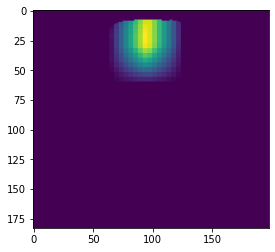

In [50]:
plt.ion()
plt.figure()
plt.imshow(label_aggr_np[:,64,:])
plt.show()

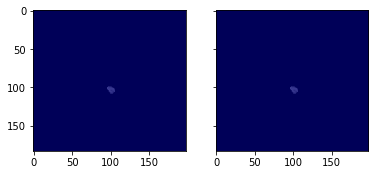

In [55]:


plt.ioff()
camera = video_comparison([brain_tensor_np, brain_tensor_np], 
                          [label_np, label_aggr_np], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
# val_labels = val_dataloader.dataset.labels

# plt.ion()
# plt.figure()
# plt.bar(val_labels, dices)
# exp_name = logdir.split('/')[1]
# plt.title(f'Validation')
# plt.ylabel('Dice score')
# plt.xticks(rotation=45)
# plt.show()

In [6]:
# tio.data.PatchSampler()

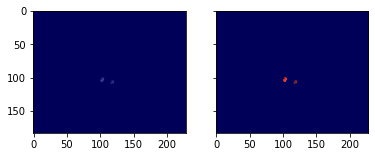

In [26]:
ind = np.argmax(dices)
plt.ioff()
camera = video_comparison([brains[ind], brains[ind]], 
                          [labels[ind], labels_pred[ind]], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation